In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [3]:
dealer_data = pd.read_csv('dealer/dealer_data.csv')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (75,76,77,78,79,105,106,122,123,128,130,132,134,171,172,178,189) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# List of relevant columns, including the recovery rate
relevant_columns = [
    'DealCSP', 'PrimaryDealer', 'C2D_Dealer', 'TradeSize', 'C2Ctrades', 'C2Dvolume_PAR', 
    'TradePreCount', 'TradePreVolume', 'TimeToMaturity', 'TimeSinceOffering', 'Default', 
    'TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10',
    'Markup', 'predicted_Primary', 'Rating', 'Commission', 'PostDummy', 'IndustryDefaultRate', 
    'UncertaintyIndex', 'PriceDistance', 'RR_Price'
]

# Limit the DataFrame to the relevant columns
dealer_df_limited = dealer_data[relevant_columns]

# rename DealCSP to CUSIP
dealer_df_limited.rename(columns={'DealCSP': 'CUSIP'}, inplace=True)

# rename RR_price to dealer_RR
dealer_df_limited.rename(columns={'RR_Price': 'dealer_RR'}, inplace=True)

# Display the first few rows of the limited DataFrame
dealer_df_limited.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,CUSIP,PrimaryDealer,C2D_Dealer,TradeSize,C2Ctrades,C2Dvolume_PAR,TradePreCount,TradePreVolume,TimeToMaturity,TimeSinceOffering,...,TRADE_CHAIN10,Markup,predicted_Primary,Rating,Commission,PostDummy,IndustryDefaultRate,UncertaintyIndex,PriceDistance,dealer_RR
0,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,97.0,33307000.0,6.622163,7.379901,...,NaN,0.002085,0.151936,17.0,0.002085,1.0,0.832444,275.808527,-0.064324437,47.9600
1,00126VAB6,0.0,df8e2728f63ee1112e65ccc34a2e6dd006d9825e,SmallInstitutional,0.0,965000.0,98.0,33317000.0,6.620745,7.380565,...,NaN,-1.000000,0.007963,17.0,NaN,1.0,0.832444,275.808527,-0.024456522,46.0000
2,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,98.0,33317000.0,6.620559,7.380652,...,NaN,0.002085,0.151791,17.0,0.002085,1.0,0.832444,275.808527,-0.064324437,47.9600
3,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,99.0,34282000.0,6.619243,7.381267,...,NaN,0.004168,0.151671,17.0,0.004168,1.0,0.832444,275.808527,-0.062379206,47.8605
4,00126VAB6,0.0,4453917d43ee60954c145536e3ea07bc15324c59,LargeInstitutional,2.0,1000000.0,100.0,34292000.0,6.605873,7.387446,...,NaN,0.005464,0.076537,17.0,0.005464,1.0,0.832444,245.097169,-0.019125683,45.7500


In [13]:
llm_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [14]:
qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(llm_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

for emotion in emotions:
    llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
    llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
    scaler = MinMaxScaler()
    llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

# transfrom language_accessibility_x and language_accessibility_y to language_accessibility
llm_output['language_accessibility'] = (llm_output['language_accessibility_x'] + llm_output['language_accessibility_y']) / 2
llm_output.drop(['language_accessibility_x', 'language_accessibility_y'], axis=1, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,joy_analysts,nervousness_analysts,optimism_analysts,pride_analysts,realization_analysts,relief_analysts,remorse_analysts,sadness_analysts,surprise_analysts,language_accessibility
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.0,0.966905,0.0,0.145973,0.0,0.0,0.0,0.457073,0.805556
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.151184,0.0,0.000000,0.0,0.0,0.0,0.000000,0.833333
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.642977,0.0,0.082452,0.0,0.030370,0.0,0.0,0.0,0.607991,0.777778
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.000000,0.0,0.230339,0.0,0.164301,0.0,0.0,0.0,0.118028,0.861111
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.000000,0.0,0.212880,0.0,0.062939,0.0,0.0,0.0,0.000000,0.694444


In [15]:
dealer_df = pd.merge(dealer_df_limited, llm_output, on='CUSIP', how='inner')

In [16]:
# List of trade chain columns
trade_chain_cols = ['TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10']

# Calculate chain length
dealer_df['transaction_chain_length'] = dealer_df[trade_chain_cols].notna().sum(axis=1) + 1  # +1 for the initial trade

In [17]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [18]:
# Select the supporting features, nlp_lables, and RR from final_df
final_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + presentation_labels 
                    + qna_labels
                    #+ emotions
                    #+ analyst_emotions
                    ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

In [19]:
'''SET PRIMARY DEALER'''
PRIMARY = True

if PRIMARY:
    final_df = final_df[final_df['PrimaryDealer'] == 1]
else:
    final_df = final_df[final_df['PrimaryDealer'] == 0]

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     114.5
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:25:47   Log-Likelihood:                -11835.
No. Observations:                2745   AIC:                         2.371e+04
Df Residuals:                    2723   BIC:                         2.384e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     19

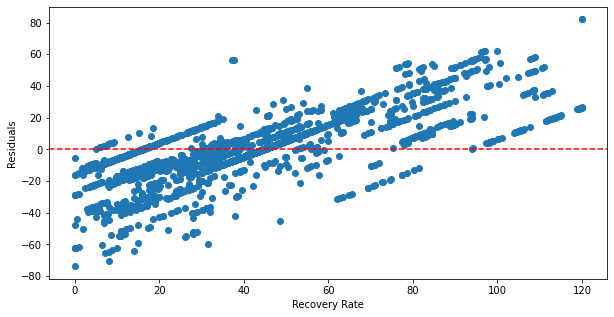

In [20]:
'''Dealer Recovery Rate Prediction'''
 # In-Sample-Regression: Recovery Rate
y_train, y_test = final_df['dealer_RR'], final_df['dealer_RR']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [21]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                  Features          VIF
22  language_accessibility          inf
7   language_accessibility          inf
0                    const  4066.725264
5              pessimistic    51.541547
1       negative_sentiment    40.288934
2       positive_sentiment    31.717239
4               optimistic    18.824421
3              uncertainty    18.667940
6                vagueness    12.285419
15           macroeconomic    11.099021
14            legal_issues     8.875948
21    analyst_satisfaction     7.970249
17          responsiveness     7.744603
16        analyst_concerns     7.461424
10      operational_trends     7.195088
13     recovery_strategies     6.953651
18              confidence     6.714536
11    industry_positioning     6.377824
19             evasiveness     4.776427
8       liquidity_position     4.251963
12           asset_quality     3.992536
20                   depth     3.101478
9     debt_leverage_stress     1.384633


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


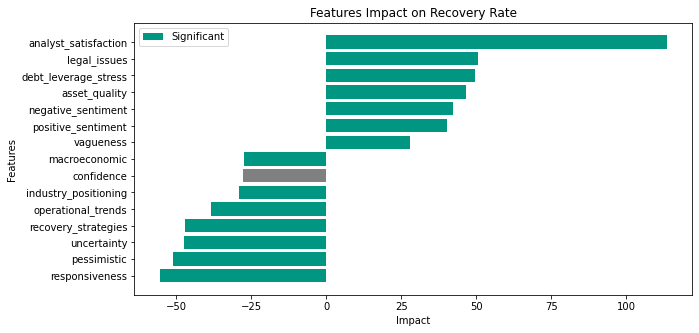

In [22]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# add legend
plt.legend(['Significant', 'Not Significant'])
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Features Impact on Recovery Rate')
plt.show()

In [ ]:
'''Transaction Chain Length Prediction'''
# In-Sample-Regression: Transaction Chain Length
y_train, y_test = final_df['transaction_chain_length'], final_df['transaction_chain_length']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [ ]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

In [ ]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# add legend
plt.legend(['Significant', 'Not Significant'])
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Features Impact on Recovery Rate')
plt.show()

In [ ]:
'''Primary Dealer Classification'''
'''Is the probability of being a primary dealer related to earnings call features?'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

logreg = LogisticRegression()
forest = RandomForestClassifier()
svm = SVC()

feature_sets = {'Financial Data 1': supporting_features_1, 
                'Financial Data 2': supporting_features_2, 
                'Presentation Labels': llm_labels, 
                'Q&A Labels':qna_labels, 
                'Management Emotions': emotions, 
                'Analyst Emotions': analyst_emotions,
                'Financial Data 1&2': supporting_features_1 + supporting_features_2,
                'LLM Labels': llm_labels + qna_labels,
                'All Emotions': emotions + analyst_emotions,
                'All combined': llm_labels + qna_labels + emotions + analyst_emotions
                }


for key in feature_sets:
    # Set features (earnings call features) and target (PrimaryDealer)
    final_df = dealer_df[['PrimaryDealer'] + feature_sets[key]]

    final_df = final_df.drop_duplicates()

    X = final_df.drop(columns='PrimaryDealer')
    y = final_df['PrimaryDealer']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit logistic regression model
    logreg.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    forest.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_log = logreg.predict(X_test)
    y_pred_svm= svm.predict(X_test)
    y_pred_forest = forest.predict(X_test)

    log_accuracy = accuracy_score(y_test, y_pred_log)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    forest_accuracy = accuracy_score(y_test, y_pred_forest)

    log_matrix = confusion_matrix(y_test, y_pred_log)

    print(f"Features: {key}")
    print(f"Accuracy Logistic Regression: {log_accuracy}")
    print(f"Confusion Matrix: {log_matrix}")  
    print(f"Accuracy SVM: {svm_accuracy}")
    print(f"Accuracy Random Forest: {forest_accuracy}")
    print('---------------------------------')
